In [1]:
## Imports ##
import RNA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from Bio.Seq import Seq
from Bio import motifs
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential, Model
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers import UpSampling1D

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

Using TensorFlow backend.


In [2]:
## Read in Sequence Data

# Raw Data
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv',index_col=0)
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

In [3]:
## Attempt to Calculate Dataset Entropy Using 8-Mers
# 8mers are the functional unit of the author's CNN model (looks at 1 8mer at a time)
# so see how entropic this dataset is in terms of 8mer distribution?
# ** This doesn't get at length distributions, or the associated MRL values. Likely a better way exists...

all_sequences = df['utr'].values
dict_8mers = {}

for j,s in enumerate(all_sequences):
    for i in range(len(s)-7):
        ss = s[i:i+8]
        dict_8mers[ss] = dict_8mers.get(ss, 0) + 1
    if (j+1) % 10000 == 0:
        print j

9999
19999
29999
39999
49999
59999
69999
79999
89999
99999
109999
119999
129999
139999
149999
159999
169999
179999
189999
199999
209999
219999
229999
239999
249999
259999
269999
279999


In [4]:
df_8mers = pd.DataFrame([{ 'utr':s, 'count':n} for s,n in dict_8mers.items()])
df_8mers.to_csv('./saved_data/8mer_counts.csv')

In [5]:
from math import log

In [6]:
## Compute dataset informational entropy on an 8mer basis

# function is H(X) = - sum_over_all_x( P(x)*log_2(P(x) )   bits

h_entropy = 0

for s,count in dict_8mers.items():
    prob_s = count / 280000.0
    h_entropy += prob_s * log(prob_s,2) 

h_entropy *= -1

print h_entropy, 'bits of entropy, computed in units of 8mers'

449.402861699 bits of entropy, computed in units of 8mers


## Data Autoencoding

In [7]:
## Split into Train, Validation, and Test Datasets

# Stay sorted by read count, at least for now

# The test set has 25k sequences
# The validation set has 15k sequences 
# The train set has 230k sequences
test = df[:25000].copy()
validate = df[25000:40000].copy()
train = df[40000:280000].copy()

# Scale the label (column name = 'rl') for each dataset independently, to avoid info leakage
test['scaled_rl'] = preprocessing.StandardScaler().fit_transform(test['rl'].values.reshape(-1,1))
validate['scaled_rl'] = preprocessing.StandardScaler().fit_transform(validate['rl'].values.reshape(-1,1))
train['scaled_rl'] = preprocessing.StandardScaler().fit_transform(train['rl'].values.reshape(-1,1))

# Label the datasets
test['dataset'] = 'test'
validate['dataset'] = 'validate'
train['dataset'] = 'train'

In [8]:
def one_hot_encode(seqs,add_context=False):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1], 'N':[0,0,0,0]}
    
    if add_context:
        seqs = [ upstream_constant[-25:]+s+eGFP[:25] for s in seqs ]
    
    # Creat empty matrix.
    vectors=np.empty([len(seqs),len(seqs[0]),4])
    
    # Encode sequences
    for i,seq in enumerate(seqs):
        a = [ nuc_d[bp] for bp in seq ]
        vectors[i] = a
    
    return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

In [9]:
x_train = one_hot_encode(train['utr'].values)
x_valid = one_hot_encode(validate['utr'].values)
x_test = one_hot_encode(test['utr'].values)

In [10]:
# Small Autoencoder

small_auto = Sequential()
# Encoder
small_auto.add(Conv1D(filters=20,kernel_size=8, 
                      activation="relu", input_shape=(50, 4), padding="same")) 
small_auto.add(MaxPooling1D(pool_size=5,padding="same")) 
small_auto.add(Conv1D(filters=10,kernel_size=8,
                      activation="relu", padding="same")) 
# Decoder
small_auto.add(Conv1D(filters=20,kernel_size=8,
                      activation="relu", padding="same")) 
small_auto.add(UpSampling1D(size=5))
small_auto.add(Conv1D(filters=4,kernel_size=8,
                      activation="sigmoid", padding="same")) 

small_auto.summary()

W1023 14:06:03.953371 4473021888 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1023 14:06:03.968111 4473021888 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1023 14:06:03.971187 4473021888 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1023 14:06:04.013513 4473021888 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 50, 20)            660       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 20)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 10)            1610      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 20)            1620      
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 50, 20)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 50, 4)             644       
Total params: 4,534
Trainable params: 4,534
Non-trainable params: 0
_________________________________________________________________


In [12]:
small_encoder = Model(inputs=small_auto.inputs,output=small_auto.get_layer("conv1d_2").output)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [13]:
np.random.seed(1338)
small_auto.compile(optimizer='adam', loss='binary_crossentropy')
small_auto.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                validation_data=(x_test, x_test))

W1023 14:06:16.969810 4473021888 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1023 14:06:16.991705 4473021888 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W1023 14:06:16.996956 4473021888 deprecation.py:323] From /usr/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_impl.py:180: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1023 14:06:17.215668 4473021888 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 240000 samples, validate on 25000 samples
Epoch 1/10
240000/240000 [==============================] - 23s 96us/step - loss: 0.4077 - val_loss: 0.3712
Epoch 2/10
240000/240000 [==============================] - 23s 96us/step - loss: 0.3374 - val_loss: 0.3269
Epoch 3/10
240000/240000 [==============================] - 21s 88us/step - loss: 0.3032 - val_loss: 0.2994
Epoch 4/10
240000/240000 [==============================] - 22s 93us/step - loss: 0.2831 - val_loss: 0.2856
Epoch 5/10
240000/240000 [==============================] - 21s 87us/step - loss: 0.2742 - val_loss: 0.2793
Epoch 6/10
240000/240000 [==============================] - 22s 91us/step - loss: 0.2691 - val_loss: 0.2754
Epoch 7/10
240000/240000 [==============================] - 22s 93us/step - loss: 0.2655 - val_loss: 0.2725
Epoch 8/10
240000/240000 [==============================] - 18s 77us/step - loss: 0.2627 - val_loss: 0.2692
Epoch 9/10
240000/240000 [==============================] - 21s 89us/step - loss: 0.2

(<Figure size 576x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12c7fc850>)

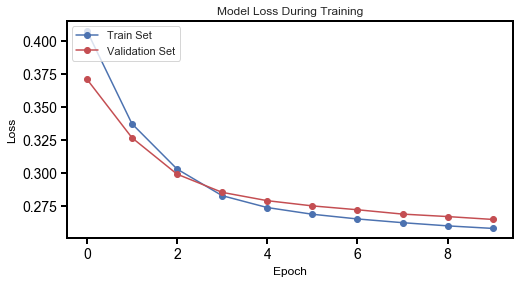

In [14]:
def display_latest_train_history(model):
    # can do for accuracy as well; check model.history.history.keys() to see what params were recorded
    # summarize history for loss
    fig,ax = plt.subplots(figsize=(8,4))
    ax.plot(model.history.history['loss'],color='b',marker='o')
    ax.plot(model.history.history['val_loss'],color='r',marker='o')
    ax.set_title('Model Loss During Training')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train Set', 'Validation Set'], loc='upper left')
    return fig,ax
display_latest_train_history(small_auto)

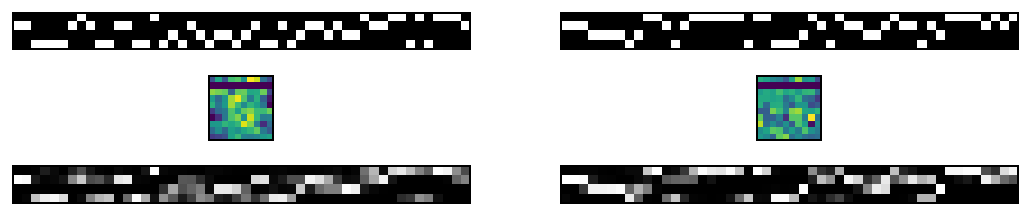

In [15]:
num_seqs = 2
np.random.seed(42)
random_test_seqs = np.random.randint(x_test.shape[0], size=num_seqs)

encoded_seqs = small_encoder.predict(x_test)
decoded_seqs = small_auto.predict(x_test)

plt.figure(figsize=(18, 4))

for i, seq_ind in enumerate(random_test_seqs):
    # plot original sequence
    ax = plt.subplot(3, num_seqs, i + 1)
    plt.imshow(x_test[seq_ind].transpose())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded sequence
    ax = plt.subplot(3, num_seqs, num_seqs + i + 1)
    plt.imshow(encoded_seqs[seq_ind].transpose())
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed sequence
    ax = plt.subplot(3, num_seqs, 2*num_seqs + i + 1)
    plt.imshow(decoded_seqs[seq_ind].transpose()) #.reshape(50,4)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [24]:
# Large Autoencoder

auto = Sequential()
# Encoder
auto.add(Conv1D(filters=60,kernel_size=8, 
                      activation="relu", input_shape=(50, 4), padding="same")) 
auto.add(MaxPooling1D(pool_size=5,padding="same")) 
auto.add(Conv1D(filters=30,kernel_size=8,
                      activation="relu", padding="same")) 
#auto.add(MaxPooling1D(pool_size=5,padding="same")) 
auto.add(Conv1D(filters=10,kernel_size=8,
                      activation="relu", padding="same")) 

# Decoder
auto.add(Conv1D(filters=10,kernel_size=8,
                      activation="relu", padding="same")) 
#auto.add(UpSampling1D(size=2))
auto.add(Conv1D(filters=30,kernel_size=8,
                      activation="relu", padding="same")) 
auto.add(UpSampling1D(size=5))
auto.add(Conv1D(filters=60,kernel_size=8,
                      activation="relu", padding="same")) 
auto.add(Conv1D(filters=4,kernel_size=8,
                      activation="sigmoid", padding="same"))


auto.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 50, 60)            1980      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 10, 60)            0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 10, 30)            14430     
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 10, 10)            2410      
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 10, 10)            810       
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 10, 30)            2430      
_________________________________________________________________
up_sampling1d_10 (UpSampling (None, 50, 30)            0         
__________

In [25]:
encoder = Model(inputs=auto.inputs,outputs=auto.get_layer('conv1d_37').output)

In [26]:
np.random.seed(1338)
auto.compile(optimizer='adam', loss='binary_crossentropy')
auto.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                validation_data=(x_test, x_test))

Train on 240000 samples, validate on 25000 samples
Epoch 1/10
240000/240000 [==============================] - 72s 302us/step - loss: 0.3944 - val_loss: 0.3089
Epoch 2/10
240000/240000 [==============================] - 53s 220us/step - loss: 0.2566 - val_loss: 0.2269
Epoch 3/10
240000/240000 [==============================] - 59s 244us/step - loss: 0.1973 - val_loss: 0.1873
Epoch 4/10
240000/240000 [==============================] - 59s 246us/step - loss: 0.1651 - val_loss: 0.1614
Epoch 5/10
240000/240000 [==============================] - 59s 246us/step - loss: 0.1520 - val_loss: 0.3009
Epoch 6/10
240000/240000 [==============================] - 59s 246us/step - loss: 0.2124 - val_loss: 0.1829
Epoch 7/10
240000/240000 [==============================] - 59s 247us/step - loss: 0.2057 - val_loss: 0.2053
Epoch 8/10
240000/240000 [==============================] - 59s 247us/step - loss: 0.1818 - val_loss: 0.1721
Epoch 9/10
240000/240000 [==============================] - 60s 251us/step - 

(<Figure size 576x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12e1e2d90>)

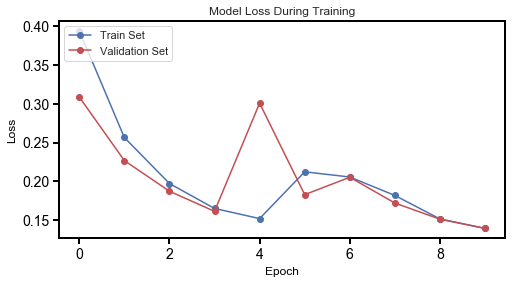

In [27]:
display_latest_train_history(auto)

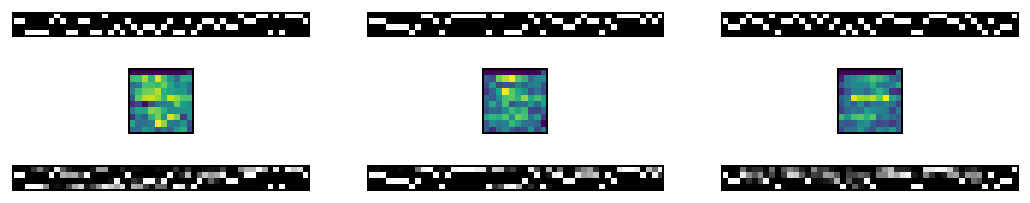

In [28]:
num_seqs = 3
np.random.seed(42)
random_test_seqs = np.random.randint(x_test.shape[0], size=num_seqs)

encoded_seqs = encoder.predict(x_test)
decoded_seqs = auto.predict(x_test)

plt.figure(figsize=(18, 4))

for i, seq_ind in enumerate(random_test_seqs):
    # plot original sequence
    ax = plt.subplot(3, num_seqs, i + 1)
    plt.imshow(x_test[seq_ind].transpose())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded sequence
    ax = plt.subplot(3, num_seqs, num_seqs + i + 1)
    plt.imshow(encoded_seqs[seq_ind].transpose())
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed sequence
    ax = plt.subplot(3, num_seqs, 2*num_seqs + i + 1)
    plt.imshow(decoded_seqs[seq_ind].transpose()) #.reshape(50,4)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()